In [1]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

In [2]:
init_notebook_mode(connected=True) 
seed = 123
random.seed = seed

In [3]:
filenames_list = os.listdir('E:/Datasets/EEg Signals/SMNI_CMI_TRAIN/Train/') 
EEG_data = pd.DataFrame({}) 

In [4]:
for file_name in tqdm(filenames_list):
    temp_df = pd.read_csv('E:/Datasets/EEg Signals/SMNI_CMI_TRAIN/' + file_name) 
    EEG_data = EEG_data.append(temp_df)
    
EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1) 
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch'

100%|██████████| 468/468 [20:38<00:00,  2.65s/it]


In [5]:
EEG_data.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


In [6]:
## replace some 'sensor position' values
EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'
## remove rows with undefined positions
EEG_data = EEG_data[(EEG_data['sensor position'] != 'X') & (EEG_data['sensor position'] != 'Y') & (EEG_data['sensor position'] != 'nd')]

In [7]:
def sample_data(stimulus, random_id=random.randint(0,7)):
    """Function merged data frame - one data frame for randomly selected subject from control group and 
    one data frame for randomly selected subject from alcoholic group"""
    ## random choose the name_id of subject from alcoholic/control group
    alcoholic_id = EEG_data['name'][(EEG_data['subject identifier'] == 'a') & 
                                    (EEG_data['matching condition'] == stimulus)].unique()[random_id]
    control_id = EEG_data['name'][(EEG_data['subject identifier'] == 'c') & 
                                  (EEG_data['matching condition'] == stimulus)].unique()[random_id]
    
    ## get min trial numbers for each group
    alcoholic_trial_number = EEG_data['trial number'][(EEG_data['name'] == alcoholic_id) & (EEG_data['matching condition'] == stimulus)].min()
    control_trial_number = EEG_data['trial number'][(EEG_data['name'] == control_id) & (EEG_data['matching condition'] == stimulus)].min()

    ## filter the EEG DF
    alcoholic_df = EEG_data[(EEG_data['name'] == alcoholic_id) & (EEG_data['trial number'] == alcoholic_trial_number)]
    control_df = EEG_data[(EEG_data['name'] == control_id) & (EEG_data['trial number'] == control_trial_number)]
    
    return alcoholic_df.append(control_df)

In [8]:
sensor_positions = EEG_data[['sensor position', 'channel']].drop_duplicates().reset_index(drop=True).drop(['channel'], axis=1).reset_index(drop=False).rename(columns={'index':'channel'})['sensor position']
channels = EEG_data[['sensor position', 'channel']].drop_duplicates().reset_index(drop=True).drop(['channel'], axis=1).reset_index(drop=False).rename(columns={'index':'channel'})['channel']

def plot_3dSurface_and_heatmap(stimulus, group, df):
    
    if group == 'c':
        group_name = 'Control'
    else:
        group_name = 'Alcoholic'
        
    temp_df = pd.pivot_table(df[['channel', 'sample num', 'sensor value']][(df['subject identifier'] == group) & (df['matching condition'] == stimulus)],
                                          index='channel', columns='sample num', values='sensor value').values.tolist()
    data = [go.Surface(z=temp_df, colorscale='Bluered')]

    layout = go.Layout(
        title='<br>3d Surface and Heatmap of Sensor Values for ' + stimulus + ' Stimulus for ' + group_name + ' Group',
        width=800,
        height=900,
        autosize=False,
        margin=dict(t=0, b=0, l=0, r=0),
        scene=dict(
            xaxis=dict(
                title='Time (sample num)',
                gridcolor='rgb(255, 255, 255)',
    #             erolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            yaxis=dict(
                title='Channel',
                tickvals=channels,
                ticktext=sensor_positions,
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230, 230)'
            ),
            zaxis=dict(
                title='Sensor Value',
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            aspectratio = dict(x=1, y=1, z=0.5),
            aspectmode = 'manual'
        )
    )

    updatemenus=list([
        dict(
            buttons=list([   
                dict(
                    args=['type', 'surface'],
                    label='3D Surface',
                    method='restyle'
                ),
                dict(
                    args=['type', 'heatmap'],
                    label='Heatmap',
                    method='restyle'
                )             
            ]),
            direction = 'left',
            pad = {'r': 10, 't': 10},
            showactive = True,
            type = 'buttons',
            x = 0.1,
            xanchor = 'left',
            y = 1.1,
            yanchor = 'top' 
        ),
    ])

    annotations = list([
        dict(text='Trace type:', x=0, y=1.085, yref='paper', align='left', showarrow=False)
    ])
    layout['updatemenus'] = updatemenus
    layout['annotations'] = annotations

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [9]:
stimulus = 'S1 obj'
S1_sample_df = sample_data(stimulus=stimulus, random_id=1)

In [10]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='a', df=S1_sample_df)

In [16]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S1_sample_df)

In [17]:
stimulus = 'S2 match'
S2_m_sample_df = sample_data(stimulus=stimulus, random_id=1)

In [18]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='a', df=S2_m_sample_df)

In [19]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S2_m_sample_df)

In [11]:
stimulus = 'S2 nomatch'
S2_nm_sample_df = sample_data(stimulus=stimulus, random_id=1)

In [13]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S2_nm_sample_df)

In [22]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S2_nm_sample_df)

In [23]:
## create the list of possible channel pairs
sample_corr_df = pd.pivot_table(S2_nm_sample_df[S2_nm_sample_df['subject identifier'] == 'a'], values='sensor value', index='sample num', columns='sensor position').corr()

list_of_pairs = []
j = 0
for column in sample_corr_df.columns:
    j += 1
    for i in range(j, len(sample_corr_df)):
        if column != sample_corr_df.index[i]:
            temp_pair = [column + '-' + sample_corr_df.index[i]]
            list_of_pairs.append(temp_pair)

In [24]:
def get_correlated_pairs_sample(threshold, correlation_df, group):
    ## create dictionary wheke keys are the pairs and values are the amount of high correlation pair
    corr_pairs_dict = {}
    for i in range(len(list_of_pairs)):
        temp_corr_pair = dict(zip(list_of_pairs[i], [0]))
        corr_pairs_dict.update(temp_corr_pair)

    j = 0
    for column in correlation_df.columns:
        j += 1
        for i in range(j, len(correlation_df)):
            if ((correlation_df[column][i] >= threshold) & (column != correlation_df.index[i])):
                corr_pairs_dict[column + '-' + correlation_df.index[i]] += 1

    corr_count = pd.DataFrame(corr_pairs_dict, index=['count']).T.reset_index(drop=False).rename(columns={'index': 'channel_pair'})
    print('Channel pairs that have correlation value >= ' + str(threshold) + ' (' + group + ' group):')
    print(corr_count['channel_pair'][corr_count['count'] > 0].tolist())

In [25]:
def plot_sensors_correlation(df, threshold_value):
    """Funtion plots the the correlation plots between sensor positions for each group"""
    correlations_alcoholic = pd.pivot_table(df[df['subject identifier'] == 'a'], 
                                          values='sensor value', index='sample num', columns='sensor position').corr()

    correlations_control = pd.pivot_table(df[df['subject identifier'] == 'c'], 
                                          values='sensor value', index='sample num', columns='sensor position').corr()

    fig = plt.figure(figsize=(17,10))
    ax = fig.add_subplot(121)
    ax.set_title('Alcoholic group', fontsize=14)
    mask = np.zeros_like(correlations_alcoholic, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_alcoholic, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax = fig.add_subplot(122)
    ax.set_title('Control group', fontsize=14)
    mask = np.zeros_like(correlations_control, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_control, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.suptitle('Correlation between Sensor Positions for ' + df['matching condition'].unique()[0] + ' stimulus', fontsize=16)
    plt.show()
    
    get_correlated_pairs_sample(threshold=threshold_value, correlation_df=correlations_alcoholic, group='Alcoholic')
    print('\n')
    get_correlated_pairs_sample(threshold=threshold_value, correlation_df=correlations_control, group='Control')

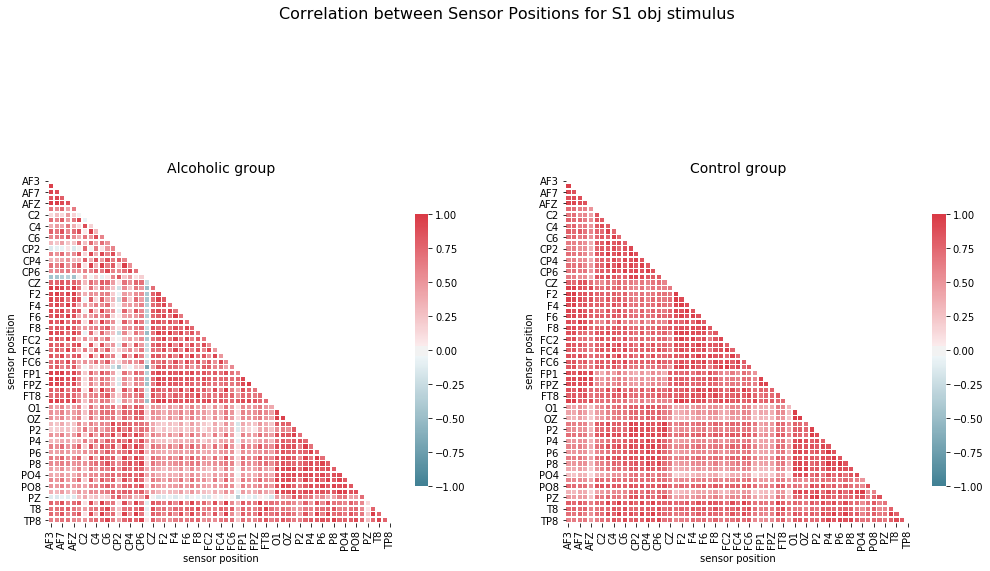

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF3-AFZ', 'AF3-F1', 'AF4-AFZ', 'AF7-FP1', 'AF8-F4', 'AF8-F6', 'AFZ-F1', 'C5-CP5', 'C5-FC5', 'C5-FT7', 'C5-T7', 'C5-TP7', 'CP3-CP5', 'CP3-P5', 'CP5-TP7', 'F1-FC1', 'F3-FC1', 'F4-F6', 'F5-F7', 'F5-FC5', 'F7-FC5', 'F7-FT7', 'FC5-FT7', 'FC5-T7', 'FP2-FPZ', 'FT7-T7', 'O1-OZ', 'P3-P5', 'P5-P7', 'PO3-POZ', 'T7-TP7']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF3-AF4', 'C5-T7', 'CP1-CP3', 'CP5-TP7', 'F1-F3', 'F1-FZ', 'F2-F4', 'F2-FZ', 'F3-F5', 'F6-F8', 'FC2-FCZ', 'O1-O2', 'O1-OZ', 'O2-OZ', 'P1-P3', 'P2-PZ', 'P4-P6', 'P4-P8', 'P5-P7', 'P6-P8', 'PO4-POZ', 'T7-TP7']


In [26]:
plot_sensors_correlation(df=S1_sample_df, threshold_value=.97)

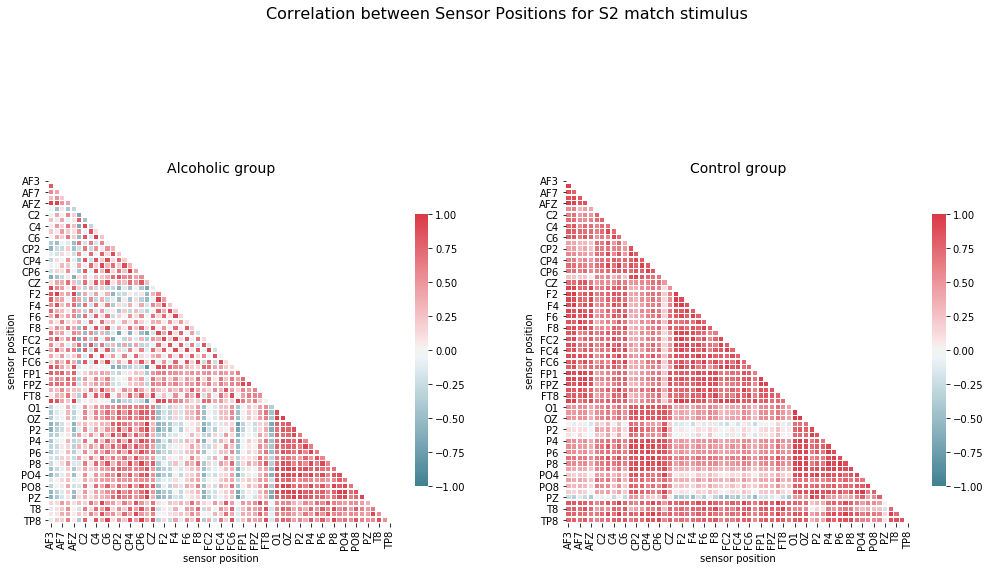

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF4-F2', 'CP4-CP6', 'CP6-TP8', 'O1-OZ', 'P1-PZ']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF4-F2', 'AF8-F8', 'AF8-FP2', 'C5-T7', 'CP3-P5', 'CP5-TP7', 'F1-F3', 'F1-FZ', 'F2-F4', 'F2-FZ', 'FT7-T7', 'O1-O2', 'O1-OZ', 'O2-OZ', 'P4-P6', 'P4-P8', 'P6-P8', 'P7-TP7', 'PO4-POZ']


In [27]:
plot_sensors_correlation(df=S2_m_sample_df, threshold_value=.97)

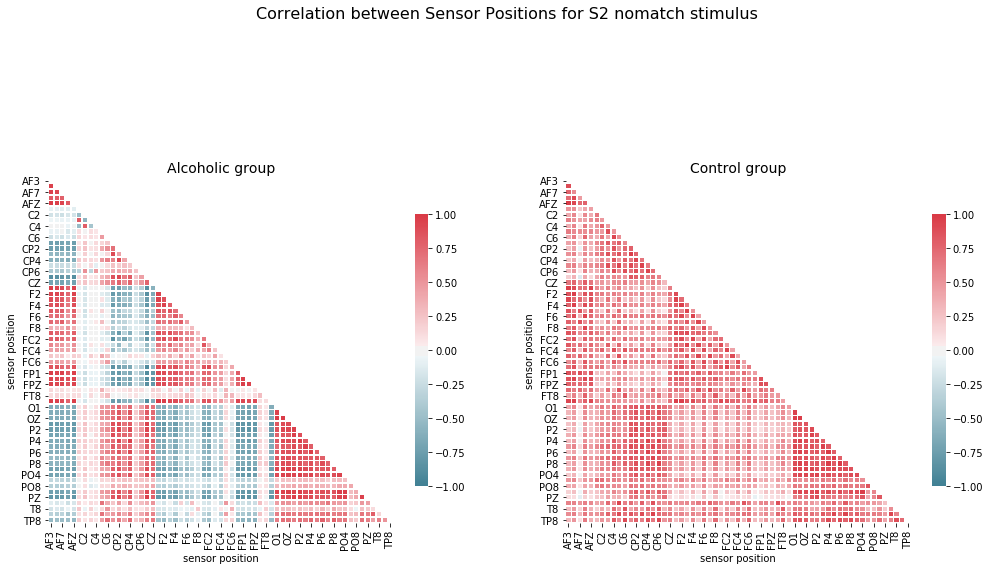

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF3-AFZ', 'AF3-F1', 'AF3-FP1', 'AF3-FZ', 'AF4-AFZ', 'AFZ-FP1', 'AFZ-FZ', 'F1-FZ', 'F2-FZ', 'FP1-FP2', 'FP1-FPZ', 'O1-OZ', 'O2-OZ', 'OZ-POZ', 'P2-P4', 'P2-PO4', 'P2-POZ', 'P2-PZ', 'P4-P6', 'PO3-POZ', 'PO4-POZ']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF3-AFZ', 'CP1-CP3', 'O1-OZ', 'O2-OZ', 'P4-P6', 'P4-P8', 'P5-P7', 'P6-P8', 'PO4-POZ']


In [28]:
plot_sensors_correlation(df=S2_nm_sample_df, threshold_value=.97)

In [29]:
def get_correlated_pairs(stimulus, threshold, group):
    """Funtion returns the df which holds pairs of channel with high correlation for stimulus, group and threshold provided"""
    corr_pairs_dict = {}
    trial_numbers_list = EEG_data['trial number'][(EEG_data['subject identifier'] == group) & (EEG_data['matching condition'] == stimulus)].unique()
    ## create dictionary wheke keys are the pairs and values are the amount of high correlation pair
    for i in range(len(list_of_pairs)):
        temp_corr_pair = dict(zip(list_of_pairs[i], [0]))
        corr_pairs_dict.update(temp_corr_pair)

    for trial_number in trial_numbers_list:    
        correlation_df = pd.pivot_table(EEG_data[(EEG_data['subject identifier'] == group) & (EEG_data['trial number'] == trial_number)], 
                                        values='sensor value', index='sample num', columns='sensor position').corr()

        j = 0 ## by setting the j we are going just through values below the main diagonal
        for column in correlation_df.columns:
            j += 1
            for i in range(j, len(correlation_df)):
                if ((correlation_df[column][i] >= threshold) & (column != correlation_df.index[i])):
                    corr_pairs_dict[column + '-' + correlation_df.index[i]] += 1

    corr_count = pd.DataFrame(corr_pairs_dict, index=['count']).T.reset_index(drop=False).rename(columns={'index': 'channel_pair'})
    corr_count['group'] = group
    corr_count['stimulus'] = stimulus
    return(corr_count)

In [30]:
def compare_corr_pairs(stimulus):
    """Function creates bar chart with the ratio of correlated pairs for both groups"""
    top_control_df = corr_pairs_df[(corr_pairs_df['group'] == 'c') & (corr_pairs_df['stimulus'] == stimulus)]
    top_alcoholic_df = corr_pairs_df[(corr_pairs_df['group'] == 'a') & (corr_pairs_df['stimulus'] == stimulus)]
    top_control_pairs = top_control_df.sort_values('count', ascending=False)['channel_pair'][:20]
    top_alcoholic_pairs = top_alcoholic_df.sort_values('count', ascending=False)['channel_pair'][:20]

    merged_df = pd.DataFrame({'channel_pair': top_control_pairs.append(top_alcoholic_pairs).unique()})
    merged_df = merged_df.merge(top_control_df[['channel_pair', 'count', 'trials_count']],
                                on='channel_pair', how='left').rename(columns={'count':'count_control', 'trials_count': 'trials_count_c'})
    merged_df = merged_df.merge(top_alcoholic_df[['channel_pair', 'count', 'trials_count']],
                                on='channel_pair', how='left').rename(columns={'count':'count_alcoholic', 'trials_count': 'trials_count_a'})

    data_1 = go.Bar(x=merged_df['channel_pair'],
                    y=(merged_df['count_alcoholic']/merged_df['trials_count_a']).apply(lambda x: round(x,2)),
                    text=merged_df['count_alcoholic'],
                    name='Alcoholic Group',
                    marker=dict(color='rgb(20,140,45)'))

    data_2 = go.Bar(x=merged_df['channel_pair'],
                    y=(merged_df['count_control']/merged_df['trials_count_c']).apply(lambda x: round(x,2)),
                    text=merged_df['count_control'],
                    name='Control Group',
                    marker=dict(color='rgb(200,100,45)'))

    layout = go.Layout(title='Amount of Correlated Pairs for the whole Data Set (' + stimulus + ' stimulus)',
                       xaxis=dict(title='Channel Pairs'),
                       yaxis=dict(title='Ratio'),
                       barmode='group')

    data = [data_1, data_2]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [31]:
corr_pairs_df = pd.DataFrame({})
stimuli_list = ['S1 obj', 'S2 match', 'S2 nomatch']
## create df that holds information of total trial amount for each subject by stimulus
size_df = EEG_data.groupby(['subject identifier', 'matching condition'])[['trial number']].nunique().reset_index(drop=False).rename(columns={'trial number':'trials_count'})

for stimulus in stimuli_list:
    corr_pairs_df = corr_pairs_df.append(get_correlated_pairs(stimulus=stimulus, threshold=.9, group='c'))
    corr_pairs_df = corr_pairs_df.append(get_correlated_pairs(stimulus=stimulus, threshold=.9, group='a'))
corr_pairs_df = corr_pairs_df.merge(size_df, left_on=['group', 'stimulus'], right_on=['subject identifier', 'matching condition'], how='left')

In [32]:
compare_corr_pairs(stimulus='S1 obj')

In [33]:
compare_corr_pairs(stimulus='S2 match')

In [34]:
compare_corr_pairs(stimulus='S2 nomatch')

In [35]:
stimulus_list = EEG_data['matching condition'].unique().tolist() ## list of stimuli
channels_list = EEG_data['channel'].unique().tolist() ## list of channels

## get the Average Sensor Values for each channel by Subject group and Stimulus
agg_df = EEG_data.groupby(['subject identifier', 'matching condition', 'sensor position'], as_index=False)[['sensor value']].mean()

In [36]:
def get_p_value(stimulus, sensor):
    """
    Funtion takes the stimulus parameter and channel number and returns the p-value from Mann Whitney U-test (Alcoholic vs Control).
    """
    x = EEG_data[['sensor value']][(EEG_data['subject identifier'] == 'a') & 
                                   (EEG_data['matching condition'] == stimulus) & 
                                   (EEG_data['sensor position'] == sensor)]
    y = EEG_data[['sensor value']][(EEG_data['subject identifier'] == 'c') & 
                                   (EEG_data['matching condition'] == stimulus) & 
                                   (EEG_data['sensor position'] == sensor)]
    stat, p = mannwhitneyu(x=x, 
                           y=y,
                           alternative='two-sided')
    return p

In [37]:
## create empty df that will hold info about the statistica test
stat_test_results = pd.DataFrame({'stimulus': [], 
                                  'sensor': [],
                                  'p_value': []})

for sensor in tqdm(EEG_data['sensor position'].unique()):
    for stimulus in EEG_data['matching condition'].unique():
        temp_df = pd.DataFrame({'stimulus': stimulus,
                                'sensor': sensor,
                                'p_value': get_p_value(stimulus=stimulus, sensor=sensor)},
                               index=[0])
        stat_test_results = stat_test_results.append(temp_df)
        
stat_test_results = stat_test_results.reset_index(drop=True)
stat_test_results['reject_null'] = stat_test_results['p_value'] <= 0.05 ## check whether we can reject null hypothesis

100%|██████████| 61/61 [18:25<00:00, 18.12s/it]


In [38]:
stat_test_results.groupby(['stimulus'])[['reject_null']].mean()

,reject_null
stimulus,
S1 obj,0.901639
S2 match,0.770492
S2 nomatch,0.803279


In [39]:
data = []
for stimulus in stimulus_list:
    trace = go.Bar(x=stat_test_results['sensor'][stat_test_results['stimulus'] == stimulus],
                    y=stat_test_results['reject_null'][stat_test_results['stimulus'] == stimulus],
                    name=stimulus)
    data.append(trace)

layout = go.Layout(title='Amount of Significant Differences for each Channel',
                   xaxis=dict(title='Sensor Position'),
                   yaxis=dict(title='Is Significant',
                              showticklabels=False),
                   barmode='stack')
fig = go.Figure(data=data, layout=layout)
iplot(fig)